In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

pd.set_option('display.max_rows', 250)

# babi-long 

In [148]:
# !cd ..; python parse_tb.py

In [181]:
res_df = pd.read_csv('../results/babilong.csv')

In [182]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


In [183]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']

In [184]:
eval_df = slc[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
# gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]

/tmp/ipykernel_1281256/3498173823.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eval_df = slc[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()


In [185]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                      \
eval_segment                         1           2           3           4      
checkpoint_segment                                                              
1                              100.000000   16.634707   15.100671   16.251198   
2                              100.000000  100.000000   99.568554   90.604027   
3                               99.952061  100.000000  100.000000  100.000000   
4                               99.928093  100.000000  100.000000  100.000000   
5                               99.616489  100.000000  100.000000  100.000000   
6                              100.000000  100.000000  100.000000  100.000000   
7                              100.000000  100.000000  100.000000  100.000000   
8                              100.000000  100.000000  100.000000  100.000000   
9                              100.000000  100.000000  100.000000  100.000000   
10                             100.000000  100.000000  100.000000  100.000000   

                                                                    \
eval_segment              5           6           7           8      
checkpoint_segment                                                   
1                    16.634707   16.922340   17.138063   16.035474   
2                    76.078617   67.857143   48.513903   39.765100   
3                   100.000000   97.579098   95.541706   93.839886   
4                   100.000000   97.722916   95.493767   93.839886   
5                   100.000000   97.579098   95.565674   93.911793   
6                   100.000000  100.000000  100.000000  100.000000   
7                   100.000000  100.000000  100.000000  100.000000   
8                   100.000000  100.000000  100.000000  100.000000   
9                   100.000000  100.000000  100.000000  100.000000   
10                  100.000000  100.000000  100.000000  100.000000   

                                            ...                         \
eval_segment              9           10    ...       19          20     
checkpoint_segment                          ...                          
1                    16.490892   17.593480  ...  15.819751   17.066155   
2                    33.077660   27.612656  ...  16.514861   16.371045   
3                    91.706615   86.697029  ...  49.784277   46.716204   
4                    91.442955   86.433369  ...  48.705658   46.236816   
5                    91.059444   86.457336  ...  49.065197   47.291468   
6                   100.000000  100.000000  ...  99.928093   99.880154   
7                   100.000000  100.000000  ...  99.976032   99.952065   
8                   100.000000  100.000000  ...        NaN         NaN   
9                   100.000000  100.000000  ...        NaN         NaN   
10                  100.000000  100.000000  ...        NaN  100.000000   

                                                                           \
eval_segment             32         64         128        256        512    
checkpoint_segment                                                          
1                         NaN        NaN        NaN        NaN        NaN   
2                         NaN        NaN        NaN        NaN        NaN   
3                         NaN        NaN        NaN        NaN        NaN   
4                         NaN        NaN        NaN        NaN        NaN   
5                         NaN        NaN        NaN        NaN        NaN   
6                         NaN        NaN        NaN        NaN        NaN   
7                   99.232979  98.226273  96.500481  95.206139  93.192711   
8                         NaN        NaN        NaN        NaN        NaN   
9                         NaN        NaN        NaN        NaN        NaN   
10                  99.137108  97.794823  96.596359  95.541710  93.624161   

                                                     
eval_segment             1024      

<Figure size 576x432 with 0 Axes>

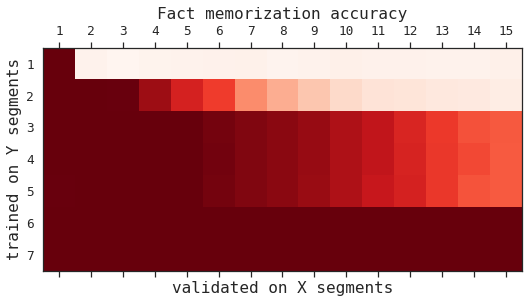

In [186]:
fs = 16
plt.figure(figsize=(8,6))
tab = table[table.columns[:15]].iloc[:7]
plt.matshow(tab.values, cmap='Reds')
plt.xlabel('validated on X segments', fontsize=fs)
plt.ylabel('trained on Y segments', fontsize=fs)
plt.xticks(range(tab.shape[1]), labels=list(map(lambda x: x[1], tab.columns)), fontsize=fs*0.8)
plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Fact memorization accuracy', fontsize=fs)
plt.savefig('img/extrapolate_hm.pdf', format='pdf')
plt.show()

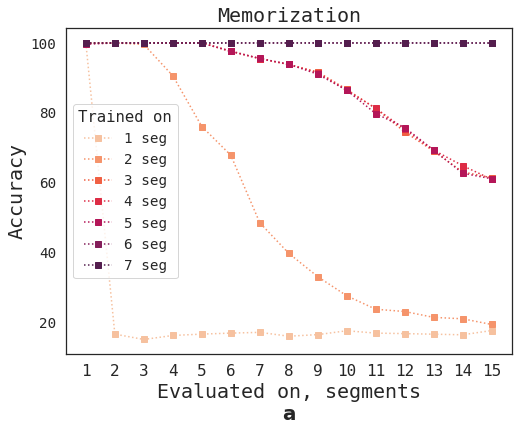

In [190]:
custom_palette = sns.color_palette("rocket_r", n_colors=8)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


# tab = table[table.columns[:15]].iloc[:7]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_exact_match')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{a}$", fontsize=fs)
plt.ylabel('Accuracy', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Memorization', fontsize=fs)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
plt.savefig('img/extrapolate.pdf', format='pdf', bbox_inches='tight')
plt.show()

# babi-long reasoning


In [10]:
# !cd ..; python parse_tb.py

In [162]:
res_df = pd.read_csv('../results/babilong_reasoning.csv')

In [163]:
# res_df = res_df[~((res_df.model_path.apply(lambda x: x[-1] == '1')) & (res_df.max_n_segments))]

In [164]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


In [165]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']

In [166]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
tmp_gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).count()[['best_valid_exact_match']]
table = pd.pivot_table(tmp_gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                     \
eval_segment                         1    2    3    4    5    6    7    8      
checkpoint_segment                                                             
1                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
2                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
3                                     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
5                                     2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
6                                     2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
7                                     2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
8                                     2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
9                                     1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                              ...                                          \
eval_segment       9    10    ... 15   16   32   64   128  256  512  1024   
checkpoint_segment            ...                                           
1                   2.0  2.0  ...  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2                   2.0  2.0  ...  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3                   1.0  1.0  ...  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4                   2.0  2.0  ...  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5                   1.0  1.0  ...  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
6                   1.0  1.0  ...  1.0  2.0  3.0  3.0  3.0  3.0  3.0  3.0   
7                   1.0  1.0  ...  1.0  2.0  3.0  3.0  3.0  3.0  3.0  3.0   
8                   1.0  1.0  ...  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
9                   NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                              
eval_segment       2048 4096  
checkpoint_segment            
1                   NaN  NaN  
2                   NaN  NaN  
3                   NaN  NaN  
4                   NaN  NaN  
5                   NaN  NaN  
6                   3.0  1.0  
7                   2.0  1.0  
8                   NaN  NaN  
9                   NaN  NaN  

[9 rows x 24 columns]

In [167]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
reason_gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]
table = pd.pivot_table(reason_gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                     \
eval_segment                         1           2           3          4      
checkpoint_segment                                                             
1                               99.825001   15.825000   19.849999  18.275001   
2                               52.025000   96.575001   91.325001  84.325001   
3                               56.000000   99.800003   99.599998  97.150002   
4                               51.150000  100.000000   99.900002  99.950001   
5                               53.824999  100.000000   99.900002  99.900002   
6                               54.650000  100.000000  100.000000  99.900002   
7                               54.350000  100.000000  100.000000  99.900002   
8                               58.074999  100.000000  100.000000  99.900002   
9                               58.049999         NaN         NaN        NaN   

                                                                             \
eval_segment              5           6          7          8          9      
checkpoint_segment                                                            
1                    16.350000   15.900000  17.475000  15.600000  16.750000   
2                    75.325001   68.700001  62.949999  54.525000  53.150002   
3                    89.150002   81.000000  77.349998  73.400002  68.699997   
4                    99.750000   99.224998  98.474998  96.924999  95.100002   
5                   100.000000  100.000000  99.599998  99.400002  98.800003   
6                    99.900002   99.699997  99.150002  98.150002  96.800003   
7                   100.000000   99.699997  98.849998  97.349998  97.550003   
8                   100.000000   99.500000  99.599998  98.949997  96.699997   
9                          NaN         NaN        NaN        NaN        NaN   

                               ...                                   \
eval_segment             10    ...       15         16         32     
checkpoint_segment             ...                                    
1                   16.725000  ...  17.000000        NaN        NaN   
2                   46.475000  ...  34.599999        NaN        NaN   
3                   64.050003  ...  56.450001        NaN        NaN   
4                   94.299999  ...  84.224998        NaN        NaN   
5                   97.949997  ...  86.849998        NaN        NaN   
6                   97.050003  ...  92.500000  92.775002  90.666667   
7                   96.150002  ...  90.949997  93.174999  91.550001   
8                   96.400002  ...  92.000000        NaN        NaN   
9                         NaN  ...        NaN        NaN        NaN   

                                                                           \
eval_segment             64         128        256        512        1024   
checkpoint_segment                                                          
1                         NaN        NaN        NaN        NaN        NaN   
2                         NaN        NaN        NaN        NaN        NaN   
3                         NaN        NaN        NaN        NaN        NaN   
4                         NaN        NaN        NaN        NaN        NaN   
5                         NaN        NaN        NaN        NaN        NaN   
6                   89.750000  88.333331  87.483332  85.933334  81.766668   
7                   89.316668  87.350001  87.566668  84.833333  83.516668   
8                         NaN        NaN        NaN        NaN        NaN   
9                         NaN        NaN        NaN        NaN        NaN   

                                          
eval_segment             2048       4096  
checkpoint_segment                        
1                         NaN        NaN  
2                         NaN        NaN  
3                         NaN        NaN  
4                         NaN        NaN  
5                         NaN 

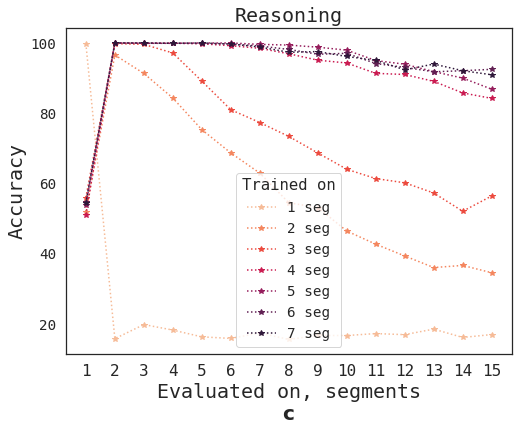

In [171]:
tab = table[table.columns[:15]].iloc[:7]

custom_palette = sns.color_palette("rocket_r", n_colors=tab.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_exact_match')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='*', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{c}$", fontsize=fs)
plt.ylabel('Accuracy', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Reasoning', fontsize=fs)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
plt.savefig('img/extrapolate_reason.pdf', format='pdf', bbox_inches='tight')
plt.show()

hm

<Figure size 144x576 with 0 Axes>

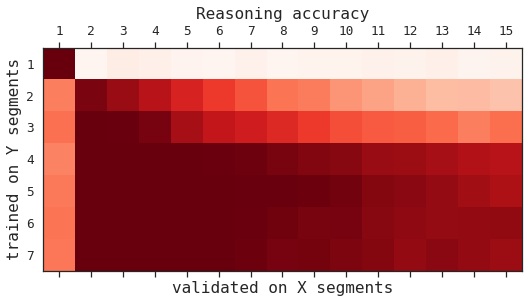

In [18]:
fs = 16
plt.figure(figsize=(2, 8))
tab_reason = table[table.columns[:15]].iloc[:7]
plt.matshow(tab_reason.values, cmap='Reds')
plt.xlabel('validated on X segments', fontsize=fs)
plt.ylabel('trained on Y segments', fontsize=fs)
plt.xticks(range(tab_reason.shape[1]), labels=list(map(lambda x: x[1], tab_reason.columns)), fontsize=fs*0.8)
plt.yticks(range(tab_reason.shape[0]), labels=tab_reason.index, fontsize=fs*0.8)
plt.title('Reasoning accuracy', fontsize=fs)
plt.savefig('img/extrapolate_reason.pdf', format='pdf', bbox_inches="tight")
plt.show()

# babi-long random V2


In [19]:
# !cd ..; python parse_tb.py

In [172]:
res_df = pd.read_csv('../results/babilong_random_v2.csv')

In [173]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


In [174]:
res_df.num_steps = res_df.num_steps.fillna(3000)
res_df = res_df[res_df.num_steps > 990]

In [175]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']
# group_df

In [176]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
random_gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).count()[['best_valid_exact_match']]
table = pd.pivot_table(random_gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                     \
eval_segment                         1    2    3    4    5    6    7    8      
checkpoint_segment                                                             
1                                     5.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0   
2                                     3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0   
3                                     3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0   
4                                     3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0   
5                                     3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0   
6                                     3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0   
7                                     3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0   
8                                     3.0  3.0  3.0  2.0  3.0  3.0  3.0  3.0   
9                                     4.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
10                                    2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   

                              ...                                          \
eval_segment       9    10    ... 16   20   32   64   128  256  512  1024   
checkpoint_segment            ...                                           
1                   3.0  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2                   3.0  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3                   3.0  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4                   3.0  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5                   3.0  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
6                   3.0  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
7                   3.0  3.0  ...  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
8                   3.0  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
9                   2.0  2.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
10                  2.0  2.0  ...  2.0  NaN  1.0  1.0  1.0  1.0  1.0  1.0   

                              
eval_segment       2048 4096  
checkpoint_segment            
1                   NaN  NaN  
2                   NaN  NaN  
3                   NaN  NaN  
4                   NaN  NaN  
5                   NaN  NaN  
6                   NaN  NaN  
7                   2.0  1.0  
8                   NaN  NaN  
9                   NaN  NaN  
10                  1.0  1.0  

[10 rows x 25 columns]

In [177]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
random_gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).max()[['best_valid_exact_match']]
table = pd.pivot_table(random_gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                      \
eval_segment                         1           2           3           4      
checkpoint_segment                                                              
1                                   100.0   18.600191   16.059444   17.353786   
2                                   100.0  100.000000   99.664429   97.027802   
3                                   100.0  100.000000  100.000000  100.000000   
4                                   100.0  100.000000  100.000000  100.000000   
5                                   100.0  100.000000  100.000000  100.000000   
6                                   100.0  100.000000  100.000000  100.000000   
7                                   100.0  100.000000  100.000000  100.000000   
8                                   100.0  100.000000  100.000000  100.000000   
9                                   100.0  100.000000  100.000000  100.000000   
10                                  100.0  100.000000  100.000000  100.000000   

                                                                    \
eval_segment              5           6           7           8      
checkpoint_segment                                                   
1                    17.881113   17.257910   17.497602   16.922338   
2                    92.042183   80.057526   65.819748   60.642376   
3                    99.952065   99.952065  100.000000   99.856186   
4                    99.952065   99.952065  100.000000   99.904121   
5                   100.000000  100.000000  100.000000  100.000000   
6                   100.000000  100.000000  100.000000   99.952065   
7                   100.000000  100.000000  100.000000  100.000000   
8                    99.952065  100.000000  100.000000  100.000000   
9                   100.000000  100.000000  100.000000  100.000000   
10                   99.952065  100.000000  100.000000  100.000000   

                                            ...                         \
eval_segment              9           10    ...        16         20     
checkpoint_segment                          ...                          
1                    17.305849   17.881113  ...         NaN        NaN   
2                    47.746883   40.124641  ...         NaN        NaN   
3                    99.856186   99.904121  ...         NaN        NaN   
4                    99.952065   99.904121  ...         NaN        NaN   
5                   100.000000  100.000000  ...         NaN        NaN   
6                    99.952065   99.904121  ...         NaN        NaN   
7                    99.952065   99.904121  ...   99.904121  99.904121   
8                   100.000000  100.000000  ...         NaN        NaN   
9                   100.000000  100.000000  ...         NaN        NaN   
10                  100.000000  100.000000  ...  100.000000        NaN   

                                                                             \
eval_segment              32          64         128        256        512    
checkpoint_segment                                                            
1                          NaN         NaN        NaN        NaN        NaN   
2                          NaN         NaN        NaN        NaN        NaN   
3                          NaN         NaN        NaN        NaN        NaN   
4                          NaN         NaN        NaN        NaN        NaN   
5                          NaN         NaN        NaN        NaN        NaN   
6                          NaN         NaN        NaN        NaN        NaN   
7                    99.808243   99.712372  98.849472  98.465965  98.561844   
8                          NaN         NaN        NaN        NaN        NaN   
9                          NaN         NaN        NaN        NaN        NaN   
10                  100.000000  100.000000  99.952065  99.952065  99.712372   

                                                     
eval_segm

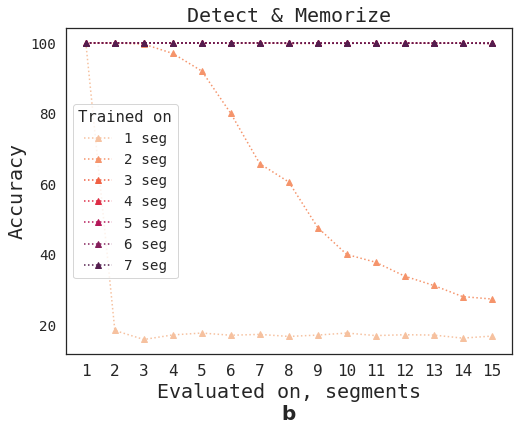

In [180]:
custom_palette = sns.color_palette("rocket_r", n_colors=8)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


tab = table[table.columns[:15]].iloc[:7]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_exact_match')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='^', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('Accuracy', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Detect & Memorize', fontsize=fs)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
plt.savefig('img/extrapolate_random.pdf', format='pdf', bbox_inches='tight')
plt.show()

### linear scale, vs gpt4

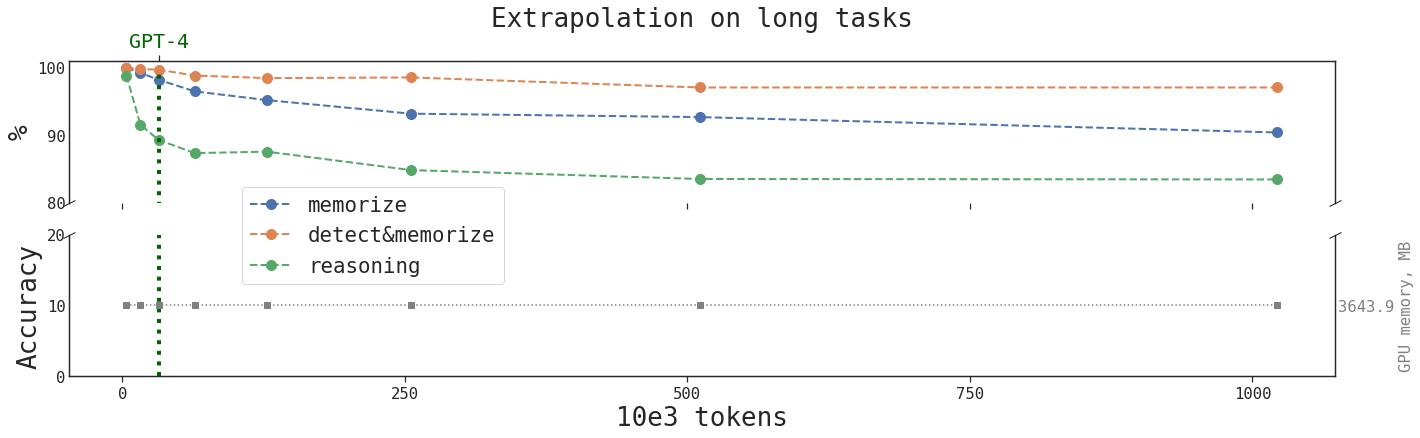

In [27]:
# custom_palette = sns.color_palette("viridis", n_colors=2)
sns.set_theme(style='white', font_scale=1.3, font='monospace')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), sharex=True)
fig.subplots_adjust(hspace=0.05) 


# regular
cpt_seg = 7
slice = gb.reset_index()[gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[((slice.eval_segment >= 32) & (slice.eval_segment <= 2048)) | (slice.eval_segment == cpt_seg)]
x_values = slice.eval_segment * 499 / 1000
y_values = slice.best_valid_exact_match
ax1.plot(x_values, y_values, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values, y_values, lw=2, markersize=10, linestyle='--', marker='o', )

#random 
cpt_seg = 7
slice = random_gb.reset_index()[random_gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[((slice.eval_segment >= 32) & (slice.eval_segment <= 2048)) | (slice.eval_segment == cpt_seg)]
x_values_random = slice.eval_segment * 499 / 1000
y_values_random = slice.best_valid_exact_match
ax1.plot(x_values_random, y_values_random, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values_random, y_values_random, lw=2, markersize=10, linestyle='--', marker='o', )


# reasoning
cpt_seg = 7
slice = reason_gb.reset_index()[reason_gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[((slice.eval_segment >= 32) & (slice.eval_segment <= 2048)) | (slice.eval_segment == cpt_seg)]
x_values_reason = slice.eval_segment * 499 / 1000
y_values_reason = slice.best_valid_exact_match
ax1.plot(x_values_reason, y_values_reason, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values_reason, y_values_reason, lw=2, markersize=10, linestyle='--', marker='o', )



# GPT-4
gpt_color = 'darkgreen'
ax4 = ax1.twiny()
ax4.get_shared_x_axes().join(ax1, ax4)
ax4.set_xticks([32], labels=['GPT-4'], fontsize=fs, color=gpt_color)
ax4.spines.bottom.set_visible(False)

# ax1.vlines(32, 0, 100, lw=4, linestyle=(0, (5, 1)), color=gpt_color)
# # ax2.vlines(32, 0, 100, lw=4, linestyle=(0, (5, 1)), color=gpt_color)
# ax1.vlines(32, 0, 100, lw=4, linestyle='solid', color=gpt_color)
# ax2.vlines(32, 0, 100, lw=4, linestyle='solid', color=gpt_color)

ax1.vlines(32, 0, 100, lw=4, linestyle='dotted', color=gpt_color)
ax2.vlines(32, 0, 100, lw=4, linestyle='dotted', color=gpt_color)

# labeling

fs = 26
ax2.set_xlabel('10e3 tokens', fontsize=fs)
ax2.set_ylabel('Accuracy', fontsize=fs)
ax1.set_ylabel('%', fontsize=fs)

ax1.set_ylim(80, 101) 
ax2.set_ylim(0, 20) 

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax1.set_yticks(range(80, 101, 10), labels=range(80, 101, 10), fontsize=fs*0.6)
ax2.set_yticks(range(0, 21, 10), labels=range(0, 21, 10), fontsize=fs*0.6)
ax2.tick_params(axis='y', length=0)
ax1.tick_params(axis='y', length=0)
xt = range(0, 2001, 250)
ax2.set_xticks(xt, labels=xt, fontsize=fs*0.6)
# ax2.legend(['memorize', 'detect&memorize', 'reasoning'], fontsize=fs*0.8, loc='lower left')
plt.figlegend(['memorize', 'detect&memorize', 'reasoning'], fontsize=fs*0.8, loc = (0.17, 0.35))

# gpu memory 
ax3 = ax2.twinx()
ax3.spines.top.set_visible(False)

color='grey'
ax3.set_ylabel('GPU memory, MB', color=color, fontsize=fs*0.6)  # we already handled the x-label with ax1
# ax3.plot([3.8, 12], [3643.9] * 2, color='grey', linestyle='dotted')
ax3.plot(x_values, [3643.9] * len(x_values), color='grey', linestyle='dotted', marker='s')
ax3.set_yticks([3643.9], labels=[3643.9], fontsize=fs*0.6)
ax3.tick_params(axis='y',length=0, labelcolor=color, labeltop=False)
fig.tight_layout()  # otherwise the right y-label is slightly clipped


# splitting lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)



ax1.set_title('Extrapolation on long tasks', fontsize=fs)
plt.savefig('img/extrapolate_long_vs_gpt4.pdf', format='pdf', bbox_inches="tight")
plt.show()

### lin scale V2


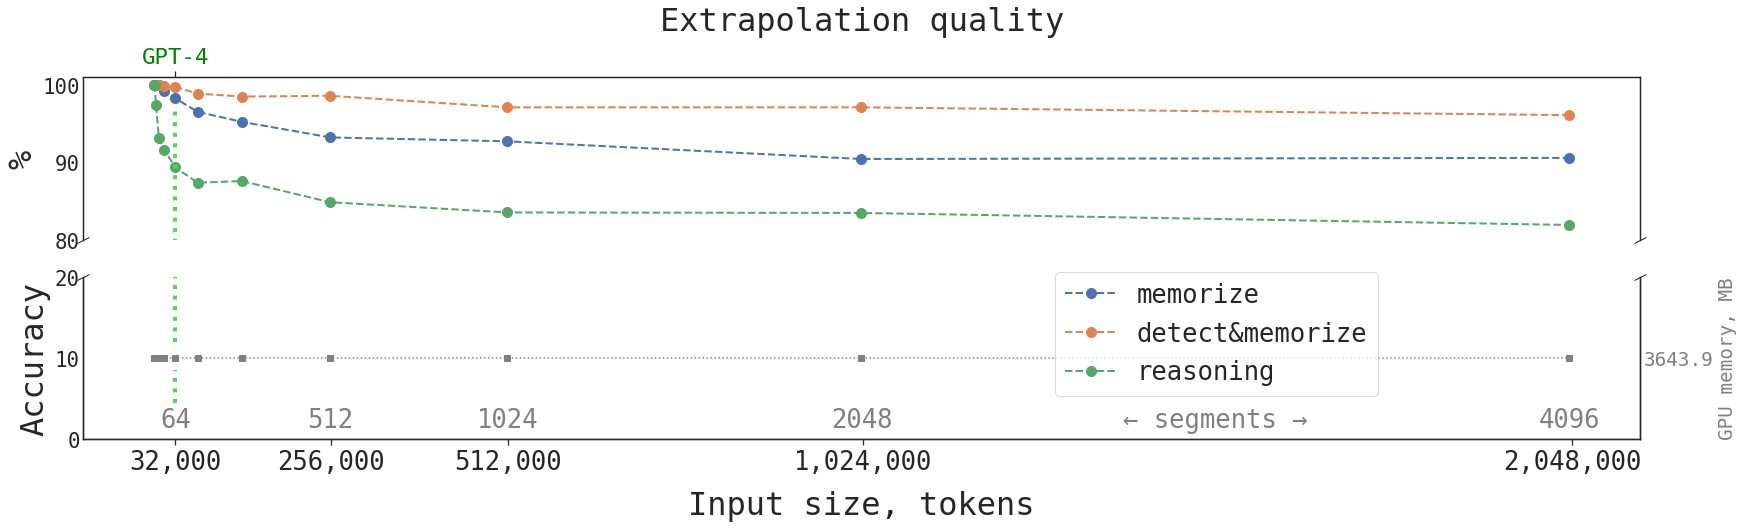

In [128]:
## tokens and segments at bottom, reversed

def written_form(number):
    thousands = int(number/1000)
    if thousands > 1000:
        millions = int(thousands / 1000)
        thousands = str(thousands)[len(str(millions)):]
        return f'{millions},{thousands},000'
    else:
        return f'{thousands},000'

sns.set_theme(style='white', font_scale=1.3, font='monospace')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 6), sharex=True)
fig.subplots_adjust(hspace=0.05) 

plotted_seg = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

# regular
cpt_seg = 7
slice = gb.reset_index()[gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[slice.eval_segment.isin(plotted_seg)]
x_values = slice.eval_segment
y_values = slice.best_valid_exact_match
ax1.plot(x_values, y_values, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values, y_values, lw=2, markersize=10, linestyle='--', marker='o', )

#random 
cpt_seg = 7
slice = random_gb.reset_index()[random_gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[slice.eval_segment.isin(plotted_seg)]
x_values_random = slice.eval_segment
y_values_random = slice.best_valid_exact_match
ax1.plot(x_values_random, y_values_random, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values_random, y_values_random, lw=2, markersize=10, linestyle='--', marker='o', )


# reasoning
cpt_seg = 7
slice = reason_gb.reset_index()[reason_gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[slice.eval_segment.isin(plotted_seg)]
x_values_reason = slice.eval_segment
y_values_reason = slice.best_valid_exact_match
ax1.plot(x_values_reason, y_values_reason, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values_reason, y_values_reason, lw=2, markersize=10, linestyle='--', marker='o', )


ax1.set_ylim(80, 101) 
ax2.set_ylim(0, 20) 

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


# labeling

fs = 32

ax1.set_yticks(range(80, 101, 10), labels=range(80, 101, 10), fontsize=fs*0.65)
ax2.set_yticks(range(0, 21, 10), labels=range(0, 21, 10), fontsize=fs*0.65)
ax2.tick_params(axis='y', length=0)
ax1.tick_params(axis='y', length=0)
plt.figlegend(['memorize', 'detect&memorize', 'reasoning'], fontsize=fs*0.8, loc = (0.605, 0.25))


# num_tokens = np.array((1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048)) * 1000
num_tokens = np.array(( 32, 256, 512, 1024, 2048)) * 1000
token_labels = [written_form(i) for i in num_tokens] 
xt_segments = list(num_tokens / 499)

segments_ticks = [64, 512, 1024, 2048, 3072, 4096]
segments_labels = list(segments_ticks)
segments_labels[4] = '← segments →'

ax4 = ax2.twiny()
ax4.get_shared_x_axes().join(ax4, ax2)

ax2.set_xticks(xt_segments, labels=token_labels, fontsize=fs*0.8)
ax4.set_xticks(segments_ticks, labels=segments_labels, fontsize=fs*0.8)

# ax4.set_xticks(xt_segments, fontsize=fs*0.5)
ax4.xaxis.set_ticks_position('bottom')
ax4.spines.top.set_visible(False)
ax4.tick_params(axis="x", direction="in", pad=-32, labelcolor='grey', length=0)


# gpu memory 
ax3 = ax2.twinx()
ax3.spines.top.set_visible(False)

color='grey'
ax3.set_ylabel('GPU memory, MB', color=color, fontsize=fs*0.6)  # we already handled the x-label with ax1
# ax3.plot([3.8, 12], [3643.9] * 2, color='grey', linestyle='dotted')
ax3.plot(x_values, [3643.9] * len(x_values), color='grey', linestyle='dotted', marker='s')
ax3.set_yticks([3643.9], labels=[3643.9], fontsize=fs*0.6)
ax3.tick_params(axis='y',length=0, labelcolor=color, labeltop=False)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# GPT-4
# gpt_color = 'green'
gpt_color = '#51DA4E'
gpt_context = 64 
gpt_linestyle = 'dotted'
gpt_alpha = 1

ax4 = ax1.twiny()
ax4.get_shared_x_axes().join(ax1, ax4)
ax4.set_xticks([gpt_context], labels=['GPT-4'], fontsize=fs*0.7, color='green')
ax4.spines.bottom.set_visible(False)
ax1.tick_params(axis='x', length=0)

ax1.vlines(gpt_context, 0, 97, lw=4, linestyle=gpt_linestyle, color=gpt_color, alpha=gpt_alpha)
ax2.vlines(gpt_context, 4.4, 8.5, lw=4, linestyle=gpt_linestyle, color=gpt_color, alpha=gpt_alpha)
ax2.vlines(gpt_context, 12, 100, lw=4, linestyle=gpt_linestyle, color=gpt_color, alpha=gpt_alpha)


# splitting lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_ylabel('Accuracy', fontsize=fs)
ax1.set_ylabel('%', fontsize=fs)
ax1.set_title('Extrapolation quality', fontsize=fs, y=1.25)
ax2.set_xlabel('Input size, tokens', fontsize=fs, labelpad=15)
plt.savefig('img/extrapolate_long_log+tok_linear.pdf', format='pdf', bbox_inches="tight")
plt.show()

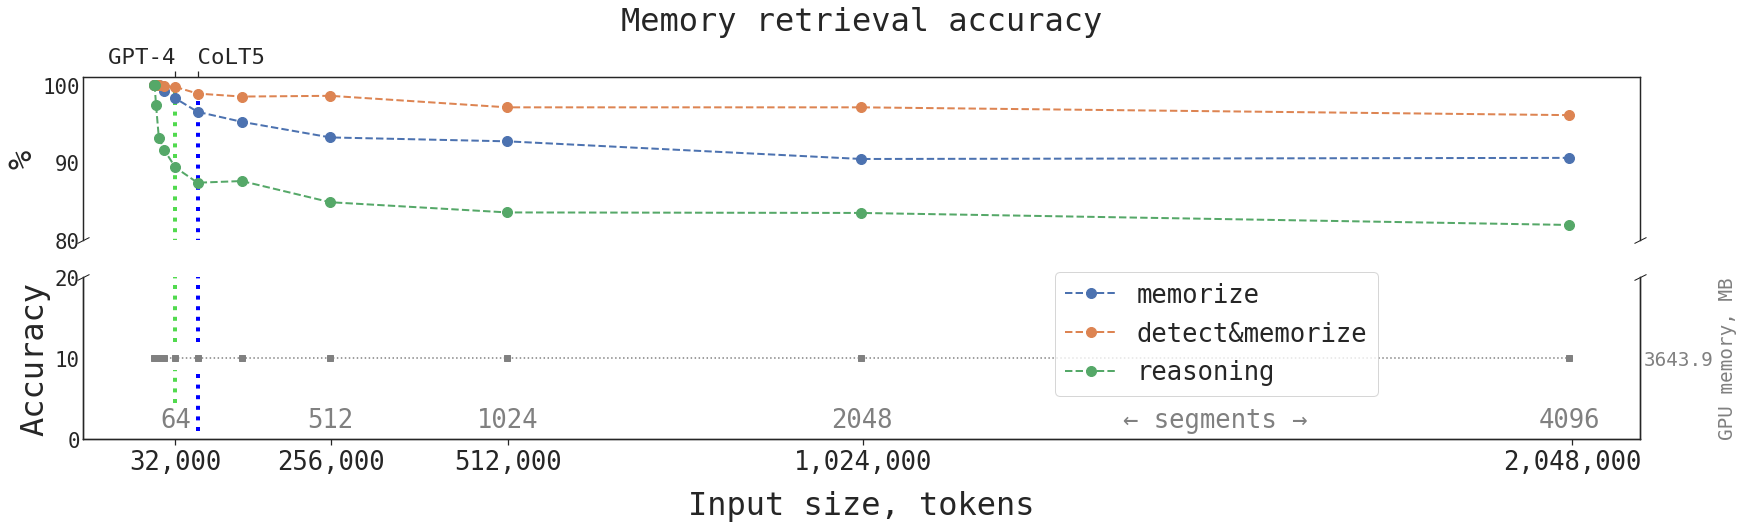

In [146]:
## + colt5

def written_form(number):
    thousands = int(number/1000)
    if thousands > 1000:
        millions = int(thousands / 1000)
        thousands = str(thousands)[len(str(millions)):]
        return f'{millions},{thousands},000'
    else:
        return f'{thousands},000'

sns.set_theme(style='white', font_scale=1.3, font='monospace')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 6), sharex=True)
fig.subplots_adjust(hspace=0.05) 

plotted_seg = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

# regular
cpt_seg = 7
slice = gb.reset_index()[gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[slice.eval_segment.isin(plotted_seg)]
x_values = slice.eval_segment
y_values = slice.best_valid_exact_match
ax1.plot(x_values, y_values, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values, y_values, lw=2, markersize=10, linestyle='--', marker='o', )

#random 
cpt_seg = 7
slice = random_gb.reset_index()[random_gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[slice.eval_segment.isin(plotted_seg)]
x_values_random = slice.eval_segment
y_values_random = slice.best_valid_exact_match
ax1.plot(x_values_random, y_values_random, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values_random, y_values_random, lw=2, markersize=10, linestyle='--', marker='o', )


# reasoning
cpt_seg = 7
slice = reason_gb.reset_index()[reason_gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[slice.eval_segment.isin(plotted_seg)]
x_values_reason = slice.eval_segment
y_values_reason = slice.best_valid_exact_match
ax1.plot(x_values_reason, y_values_reason, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values_reason, y_values_reason, lw=2, markersize=10, linestyle='--', marker='o', )


ax1.set_ylim(80, 101) 
ax2.set_ylim(0, 20) 

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


# labeling

fs = 32

ax1.set_yticks(range(80, 101, 10), labels=range(80, 101, 10), fontsize=fs*0.65)
ax2.set_yticks(range(0, 21, 10), labels=range(0, 21, 10), fontsize=fs*0.65)
ax2.tick_params(axis='y', length=0)
ax1.tick_params(axis='y', length=0)
plt.figlegend(['memorize', 'detect&memorize', 'reasoning'], fontsize=fs*0.8, loc = (0.605, 0.25))


# num_tokens = np.array((1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048)) * 1000
num_tokens = np.array(( 32, 256, 512, 1024, 2048)) * 1000
token_labels = [written_form(i) for i in num_tokens] 
xt_segments = list(num_tokens / 499)

segments_ticks = [64, 512, 1024, 2048, 3072, 4096]
segments_labels = list(segments_ticks)
segments_labels[4] = '← segments →'

ax4 = ax2.twiny()
ax4.get_shared_x_axes().join(ax4, ax2)

ax2.set_xticks(xt_segments, labels=token_labels, fontsize=fs*0.8)
ax4.set_xticks(segments_ticks, labels=segments_labels, fontsize=fs*0.8)

# ax4.set_xticks(xt_segments, fontsize=fs*0.5)
ax4.xaxis.set_ticks_position('bottom')
ax4.spines.top.set_visible(False)
ax4.tick_params(axis="x", direction="in", pad=-32, labelcolor='grey', length=0)


# gpu memory 
ax3 = ax2.twinx()
ax3.spines.top.set_visible(False)

color='grey'
ax3.set_ylabel('GPU memory, MB', color=color, fontsize=fs*0.6)  # we already handled the x-label with ax1
# ax3.plot([3.8, 12], [3643.9] * 2, color='grey', linestyle='dotted')
ax3.plot(x_values, [3643.9] * len(x_values), color='grey', linestyle='dotted', marker='s')
ax3.set_yticks([3643.9], labels=[3643.9], fontsize=fs*0.6)
ax3.tick_params(axis='y',length=0, labelcolor=color, labeltop=False)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# GPT-4, CoLT5
# gpt_color = 'green'
gpt_color = '#51DA4E'
gpt_context = 64 
gpt_linestyle = 'dotted'
gpt_alpha = 1

colt5_color = 'blue'
colt5_context = 128
colt5_linestyle = 'dotted'
colt5_alpha = 1
zorder = -100

ax4 = ax1.twiny()
ax4.get_shared_x_axes().join(ax1, ax4)
ax4.set_xticks([gpt_context, colt5_context], labels=['GPT-4' + ' '*5, ' '*5 + 'CoLT5'], fontsize=fs*0.7)

ax4_colors=['green', 'darkblue']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(ax2), ax4_colors):
    ticklabel.set_color(tickcolor)

ax4.spines.bottom.set_visible(False)
ax1.tick_params(axis='x', length=0)

ax1.vlines(gpt_context, 0, 100, lw=4, linestyle=gpt_linestyle, color=gpt_color, alpha=gpt_alpha, zorder=zorder)
ax2.vlines(gpt_context, 4.4, 8.5, lw=4, linestyle=gpt_linestyle, color=gpt_color, alpha=gpt_alpha, zorder=zorder)
ax2.vlines(gpt_context, 12, 100, lw=4, linestyle=gpt_linestyle, color=gpt_color, alpha=gpt_alpha, zorder=zorder)

ax1.vlines(colt5_context, 0, 100, lw=4, linestyle=gpt_linestyle, color=colt5_color, alpha=gpt_alpha, zorder=zorder)
ax2.vlines(colt5_context, 1, 8.5, lw=4, linestyle=gpt_linestyle, color=colt5_color, alpha=gpt_alpha, zorder=zorder)
ax2.vlines(colt5_context, 12, 100, lw=4, linestyle=gpt_linestyle, color=colt5_color, alpha=gpt_alpha, zorder=zorder)


# splitting lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_ylabel('Accuracy', fontsize=fs)
ax1.set_ylabel('%', fontsize=fs)
ax1.set_title('Memory retrieval accuracy', fontsize=fs, y=1.25)
ax2.set_xlabel('Input size, tokens', fontsize=fs, labelpad=15)
plt.savefig('img/extrapolate_long_log+tok_linear.pdf', format='pdf', bbox_inches="tight")
plt.show()

### log scale, 2


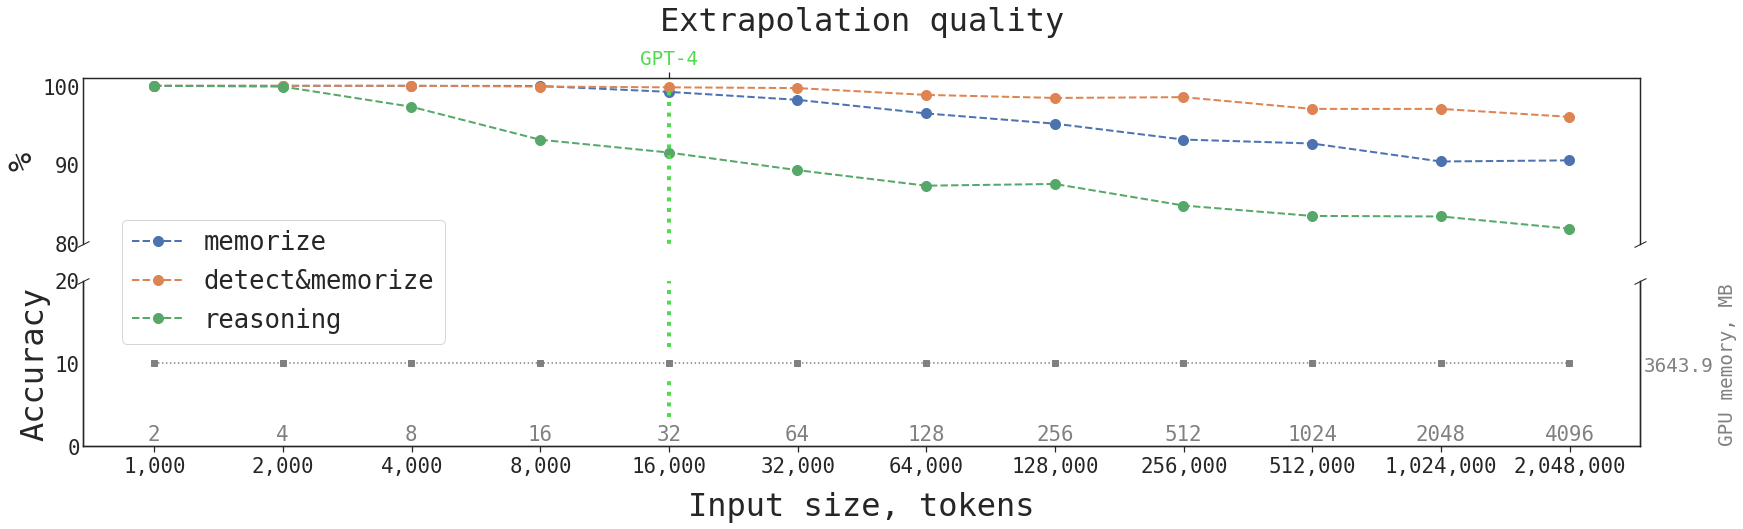

In [119]:
## tokens and segments at bottom, reversed

def written_form(number):
    thousands = int(number/1000)
    if thousands > 1000:
        millions = int(thousands / 1000)
        thousands = str(thousands)[len(str(millions)):]
        return f'{millions},{thousands},000'
    else:
        return f'{thousands},000'

sns.set_theme(style='white', font_scale=1.3, font='monospace')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 6), sharex=True)
fig.subplots_adjust(hspace=0.05) 

plotted_seg = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

# regular
cpt_seg = 7
slice = gb.reset_index()[gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[slice.eval_segment.isin(plotted_seg)]
x_values = np.log2(slice.eval_segment)
y_values = slice.best_valid_exact_match
ax1.plot(x_values, y_values, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values, y_values, lw=2, markersize=10, linestyle='--', marker='o', )

#random 
cpt_seg = 7
slice = random_gb.reset_index()[random_gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[slice.eval_segment.isin(plotted_seg)]
x_values_random = np.log2(slice.eval_segment)
y_values_random = slice.best_valid_exact_match
ax1.plot(x_values_random, y_values_random, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values_random, y_values_random, lw=2, markersize=10, linestyle='--', marker='o', )


# reasoning
cpt_seg = 7
slice = reason_gb.reset_index()[reason_gb.reset_index().checkpoint_segment == cpt_seg]
slice = slice[slice.eval_segment.isin(plotted_seg)]
x_values_reason = np.log2(slice.eval_segment)
y_values_reason = slice.best_valid_exact_match
ax1.plot(x_values_reason, y_values_reason, lw=2, markersize=10, linestyle='--', marker='o', )
ax2.plot(x_values_reason, y_values_reason, lw=2, markersize=10, linestyle='--', marker='o', )


ax1.set_ylim(80, 101) 
ax2.set_ylim(0, 20) 

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


# labeling

fs = 32

ax1.set_yticks(range(80, 101, 10), labels=range(80, 101, 10), fontsize=fs*0.65)
ax2.set_yticks(range(0, 21, 10), labels=range(0, 21, 10), fontsize=fs*0.65)
ax2.tick_params(axis='y', length=0)
ax1.tick_params(axis='y', length=0)
plt.figlegend(['memorize', 'detect&memorize', 'reasoning'], fontsize=fs*0.8, loc = (0.07, 0.35))


num_tokens = np.array((1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048)) * 1000
token_labels = [written_form(i) for i in num_tokens]
 
xt_segments = list(np.log2(num_tokens / 499))

ax4 = ax2.twiny()
ax4.get_shared_x_axes().join(ax4, ax2)

ax2.set_xticks(xt_segments, labels=token_labels, fontsize=fs*0.65)
ax4.set_xticks(np.log2(np.array(plotted_seg)), labels=plotted_seg, fontsize=fs*0.65)

# ax4.set_xticks(xt_segments, fontsize=fs*0.5)
ax4.xaxis.set_ticks_position('bottom')
ax4.spines.top.set_visible(False)
ax4.tick_params(axis="x", direction="in", pad=-22, labelcolor='grey', length=0)


# gpu memory 
ax3 = ax2.twinx()
ax3.spines.top.set_visible(False)

color='grey'
ax3.set_ylabel('GPU memory, MB', color=color, fontsize=fs*0.6)  # we already handled the x-label with ax1
# ax3.plot([3.8, 12], [3643.9] * 2, color='grey', linestyle='dotted')
ax3.plot(x_values, [3643.9] * len(x_values), color='grey', linestyle='dotted', marker='s')
ax3.set_yticks([3643.9], labels=[3643.9], fontsize=fs*0.6)
ax3.tick_params(axis='y',length=0, labelcolor=color, labeltop=False)
fig.tight_layout()  # otherwise the right y-label is slightly clipped


# GPT-4
# gpt_color = 'green'
gpt_color = '#51DA4E'
gpt_context = 5
gpt_linestyle = 'dotted'
gpt_alpha = 1

ax4 = ax1.twiny()
ax4.get_shared_x_axes().join(ax1, ax4)
ax4.set_xticks([gpt_context], labels=['GPT-4'], fontsize=fs*0.6, color=gpt_color)
ax4.spines.bottom.set_visible(False)
ax1.tick_params(axis='x', length=0)

ax1.vlines(gpt_context, 0, 100, lw=4, linestyle=gpt_linestyle, color=gpt_color, alpha=gpt_alpha)
ax2.vlines(gpt_context, 3.5, 8, lw=4, linestyle=gpt_linestyle, color=gpt_color, alpha=gpt_alpha)
ax2.vlines(gpt_context, 12, 100, lw=4, linestyle=gpt_linestyle, color=gpt_color, alpha=gpt_alpha)


# splitting lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_ylabel('Accuracy', fontsize=fs)
ax1.set_ylabel('%', fontsize=fs)

ax1.set_title('Extrapolation quality', fontsize=fs, y=1.25)
ax2.set_xlabel('Input size, tokens', fontsize=fs, labelpad=15)
plt.savefig('img/extrapolate_long_log+tok.pdf', format='pdf', bbox_inches="tight")
plt.show()